In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 12)
plt.style.use('tableau-colorblind10')

In [2]:
from IPython.display import display, Markdown
from databoost.scenario import SCENARIOS
from sklearn.metrics import roc_auc_score, brier_score_loss
import warnings

METRICS = [roc_auc_score, brier_score_loss]

best_result = []
for scenario in SCENARIOS:
    s = SCENARIOS[scenario]
    train_X, test_X, train_y, test_y = s.train_test(legacy_size=0.0, legacy_drop_frac=0.0, legacy_missing_label=0.0)
    base_pipe = s.build_pipeline(train_X)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        base_pipe.fit(train_X, train_y)
        base_scored = base_pipe.predict_proba(test_X)[:,1]
    
    row_result = {
        'scenario': scenario,
        'train_rows': len(train_y),
        'test_rows': len(test_y),
    }
    for metric in METRICS:
        row_result[str(metric.__name__)] = metric(test_y, base_scored)

    best_result.append(row_result)

display(Markdown("""# Best possible performance

This is what would be obtainable if we had no data loss.
"""))
best_result = pd.DataFrame(best_result)
best_result

# Best possible performance

This is what would be obtainable if we had no data loss.


,scenario,train_rows,test_rows,roc_auc_score,brier_score_loss
0,santander,28507,9503,0.828822,0.034558
1,car_insurance,43944,14648,0.645644,0.058750
2,tabular_playground,19927,6643,0.571627,0.166762
3,synthetic_1,75000,25000,0.920994,0.027760
4,synthetic_2_dataset_shift,75000,25000,0.896726,0.033068
5,cover_type_dataset_shift,435759,145253,0.990174,0.025713


In [3]:
from databoost.utils import SummedPredictors

# Data boosting

This model uses adaboost-style weights to build a second model that corrects the first one. The final model is merely the sum of the two.

In [4]:
from scipy.special import xlogy

def adaboost_weights(estimator, X, y, learning_rate=0.5, sample_weight=None):
    """Implement weights for a single boost using the SAMME.R real algorithm."""

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        y_predict_proba = estimator.predict_proba(X)
    if sample_weight is None:
        sample_weight = np.ones(shape=y.shape) / len(y)

    n_classes = 2
    classes = np.array([0,1])
    y_codes = np.array([-1.0 / (n_classes - 1), 1.0])
    y_coding = y_codes.take(classes == y[:, np.newaxis])

    # Displace zero probabilities so the log is defined.
    # Also fix negative elements which may occur with
    # negative sample weights.
    proba = y_predict_proba  # alias for readability
    np.clip(proba, np.finfo(proba.dtype).eps, None, out=proba)

    # Boost weight using multi-class AdaBoost SAMME.R alg
    estimator_weight = (
        -1.0
        * learning_rate
        * ((n_classes - 1.0) / n_classes)
        * xlogy(y_coding, y_predict_proba).sum(axis=1)
    )

    # Only boost positive weights
    sample_weight *= np.exp(
        estimator_weight * ((sample_weight > 0) | (estimator_weight < 0))
    )

    return sample_weight


def databoosted_pipe(train_X, train_y, scenario):
    old_idx = (train_X['legacy'] == 1)

    pipe1 = scenario.build_pipeline(train_X[old_idx])

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pipe1.fit(
            train_X[old_idx], 
            train_y[old_idx], 
        )

    sample_weight = adaboost_weights(
        pipe1, train_X[~old_idx].copy(), 
        train_y[~old_idx].copy(), 
        learning_rate=0.25,
        sample_weight=scenario.base_sample_weight(train_X[~old_idx], train_y[~old_idx]),
    )

    pipe2 = scenario.build_pipeline(train_X[~old_idx])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pipe2.fit(train_X[~old_idx], train_y[~old_idx], final_estimator__sample_weight=sample_weight)

    boosted_pipe = SummedPredictors([pipe1, pipe2], [1.0, 1.0])
    return boosted_pipe

Text(0.5, 0, 'fpr')

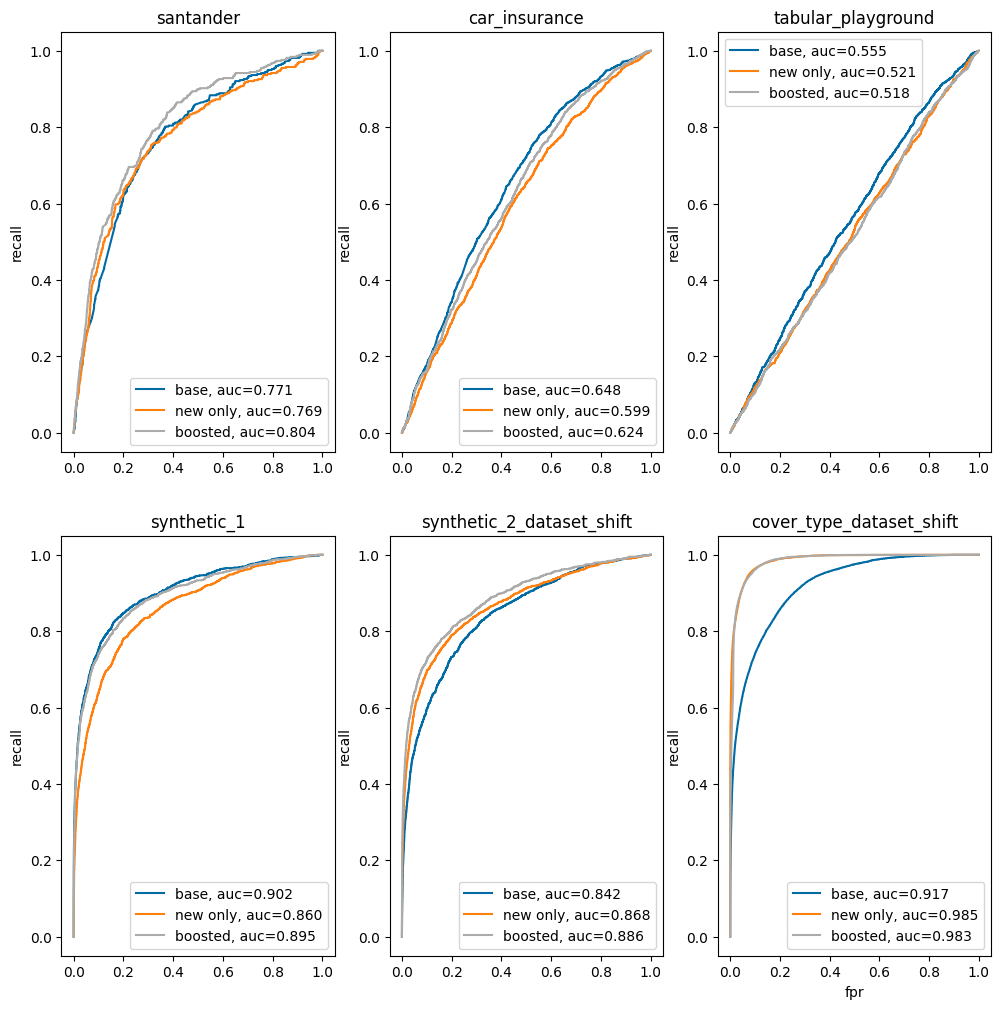

In [5]:
from sklearn.metrics import roc_auc_score, roc_curve

n_scenarios = len(SCENARIOS)
plot_cols = 3
plot_rows = int(np.ceil(n_scenarios/plot_cols))
i = 1

for scenario in SCENARIOS:
    plt.subplot(plot_rows*100+plot_cols*10+i)
    i += 1
    
    s = SCENARIOS[scenario]
    train_X, test_X, train_y, test_y = s.train_test(legacy_size=0.85, legacy_drop_frac=0.4, legacy_missing_label=0.0)
    base_pipe = s.build_pipeline(train_X)
    new_idx = ~(train_X['legacy'].astype(bool))
    new_only_pipe = s.build_pipeline(train_X[new_idx])
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        base_pipe.fit(train_X, train_y)
        new_only_pipe.fit(train_X[new_idx], train_y[new_idx])
        bp = databoosted_pipe(train_X, train_y, s)
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        base_scored = base_pipe.predict_proba(test_X)[:,1]
        new_only_scored = new_only_pipe.predict_proba(test_X)[:,1]
        boosted_scored = bp.predict_proba(test_X)[:,1]

    fpr, recall, _ = roc_curve(test_y, base_scored)
    plt.plot(fpr, recall, label='base, auc={:.3f}'.format(
        roc_auc_score(test_y, base_scored)
    ))
    fpr, recall, _ = roc_curve(test_y, new_only_scored)
    plt.plot(fpr, recall, label='new only, auc={:.3f}'.format(
        roc_auc_score(test_y, new_only_scored)
    ))
    fpr, recall, _ = roc_curve(test_y, boosted_scored)
    plt.plot(fpr, recall, label='boosted, auc={:.3f}'.format(
        roc_auc_score(test_y, boosted_scored)
    ))

    plt.title(scenario)
    plt.ylabel('recall')
    plt.legend()

plt.xlabel('fpr')


# Aggregate results

Let us now measure the benefit, across all datasets, and multiple parameter choices.

In what is seen below, `legacy_size` represents the fraction of the dataset that is missing features. This ranges from 10% to 95%,
and for each value of the parameter I do 5 iterations. Each iteration represents a different (randomly chosen) set of features
which get dropped on the legacy data set.

In [6]:
from sklearn.metrics import roc_auc_score, roc_curve
import itertools

result = []
iterations_per_scenario = 5

for scenario in SCENARIOS:
    for legacy_size, _ in itertools.product(np.arange(0.1, 1.0, 0.05), np.arange(iterations_per_scenario)):

        s = SCENARIOS[scenario]
        train_X, test_X, train_y, test_y = s.train_test(legacy_size=legacy_size, legacy_drop_frac=0.3, legacy_missing_label=0.0)
        base_pipe = s.build_pipeline(train_X)
        
        new_idx = ~(train_X['legacy'].astype(bool))
        new_only_pipe = s.build_pipeline(train_X[new_idx])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            base_pipe.fit(train_X, train_y)
            new_only_pipe.fit(train_X[new_idx], train_y[new_idx])
            bp = databoosted_pipe(train_X, train_y, s)

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            base_scored = base_pipe.predict_proba(test_X)[:,1]
            new_only_scored = new_only_pipe.predict_proba(test_X)[:,1]
            boosted_scored = bp.predict_proba(test_X)[:,1]
            
        
        row_result = {'scenario': scenario, 'legacy_size': legacy_size}
        for max_fpr in [None]:
            if max_fpr is None:
                suffix = ''
            else:
                suffix = '_{}'.format(max_fpr)
            row_result['base_roc_auc{}'.format(suffix)] = roc_auc_score(test_y, base_scored, max_fpr=max_fpr)
            row_result['boosted_roc_auc{}'.format(suffix)] = roc_auc_score(test_y, boosted_scored, max_fpr=max_fpr)
            row_result['new_only_roc_auc{}'.format(suffix)] = roc_auc_score(test_y, new_only_scored, max_fpr=max_fpr)
        
        result.append(row_result)

result = pd.DataFrame(result)


result = pd.merge(
    result,
    best_result[['scenario', 'roc_auc_score']].rename(columns={'roc_auc_score': 'full_data_auc_score'}),
    on='scenario',
    how='left'
)

result['boosted_regret'] = result['full_data_auc_score'] - result['boosted_roc_auc']
result['base_regret'] = result['full_data_auc_score'] - result['base_roc_auc']
result['new_only_regret'] = result['full_data_auc_score'] - result['new_only_roc_auc']
result['win_base'] = result['boosted_roc_auc'] > result['base_roc_auc']
result['win_new_only'] = result['boosted_roc_auc'] > result['new_only_roc_auc']
result['delta_base'] = result['boosted_roc_auc'] - result['base_roc_auc']
result['delta_new_only'] = result['boosted_roc_auc'] - result['new_only_roc_auc']
result['win_delta'] = (result['boosted_roc_auc'] - result['base_roc_auc'])*result['win_base']
result.groupby('scenario').agg({
    'win_base': 'mean',
    'win_new_only': 'mean',
    'delta_base': 'mean',
    'delta_new_only': 'mean',
    'win_delta': 'mean',
    'boosted_regret': 'mean',
    'base_regret': 'mean',
})

,win_base,win_new_only,delta_base,delta_new_only,win_delta,boosted_regret,base_regret
scenario,,,,,,,
car_insurance,0.600000,0.633333,0.016477,0.005838,0.022029,0.011399,0.027877
cover_type_dataset_shift,0.988889,0.377778,0.013555,-0.000274,0.013558,0.002864,0.016419
santander,0.500000,0.744444,0.011199,0.010309,0.014415,0.007823,0.019022
synthetic_1,0.788889,0.855556,0.007726,0.017515,0.008399,0.006620,0.014346
synthetic_2_dataset_shift,0.911111,0.844444,0.015139,0.014937,0.015884,0.017706,0.032845
tabular_playground,0.055556,0.522222,-0.015335,0.000061,0.000158,0.016729,0.001394


In [48]:
result['new_only_regret'] = result['full_data_auc_score'] - result['new_only_roc_auc']
result.groupby('scenario').agg({
    'win_base': 'mean',
    'win_new_only': 'mean',
    'delta_base': 'mean',
    'delta_new_only': 'mean',
    'win_delta': 'mean',
    'boosted_regret': 'mean',
    'base_regret': 'mean',
    'new_only_regret': 'mean',
})

,win_base,win_new_only,delta_base,delta_new_only,win_delta,boosted_regret,base_regret,new_only_regret
scenario,,,,,,,,
car_insurance,0.600000,0.633333,0.016477,0.005838,0.022029,0.011399,0.027877,0.017238
cover_type_dataset_shift,0.988889,0.377778,0.013555,-0.000274,0.013558,0.002864,0.016419,0.002590
santander,0.500000,0.744444,0.011199,0.010309,0.014415,0.007823,0.019022,0.018132
synthetic_1,0.788889,0.855556,0.007726,0.017515,0.008399,0.006620,0.014346,0.024135
synthetic_2_dataset_shift,0.911111,0.844444,0.015139,0.014937,0.015884,0.017706,0.032845,0.032643
tabular_playground,0.055556,0.522222,-0.015335,0.000061,0.000158,0.016729,0.001394,0.016790


## Dataset shift

Let me repeat the above experiment, but I'll impose an additional constraint on the data: on the legacy data, 20% of labels will be (wrongly)
set to zero.

In [49]:
print(result.groupby('scenario').agg({
    'win_base': 'mean',
    'win_new_only': 'mean',
    'delta_base': 'mean',
    'delta_new_only': 'mean',
#    'win_delta': 'mean',
    'boosted_regret': 'mean',
    'base_regret': 'mean',
    'new_only_regret': 'mean',
}).to_markdown())

| scenario                  |   win_base |   win_new_only |   delta_base |   delta_new_only |   boosted_regret |   base_regret |   new_only_regret |
|:--------------------------|-----------:|---------------:|-------------:|-----------------:|-----------------:|--------------:|------------------:|
| car_insurance             |  0.6       |       0.633333 |   0.0164774  |      0.00583833  |       0.0113992  |    0.0278766  |        0.0172375  |
| cover_type_dataset_shift  |  0.988889  |       0.377778 |   0.0135553  |     -0.000273961 |       0.0028636  |    0.0164189  |        0.00258964 |
| santander                 |  0.5       |       0.744444 |   0.0111991  |      0.0103093   |       0.00782312 |    0.0190222  |        0.0181324  |
| synthetic_1               |  0.788889  |       0.855556 |   0.00772637 |      0.017515    |       0.00661954 |    0.0143459  |        0.0241345  |
| synthetic_2_dataset_shift |  0.911111  |       0.844444 |   0.015139   |      0.0149367   |       0.0177

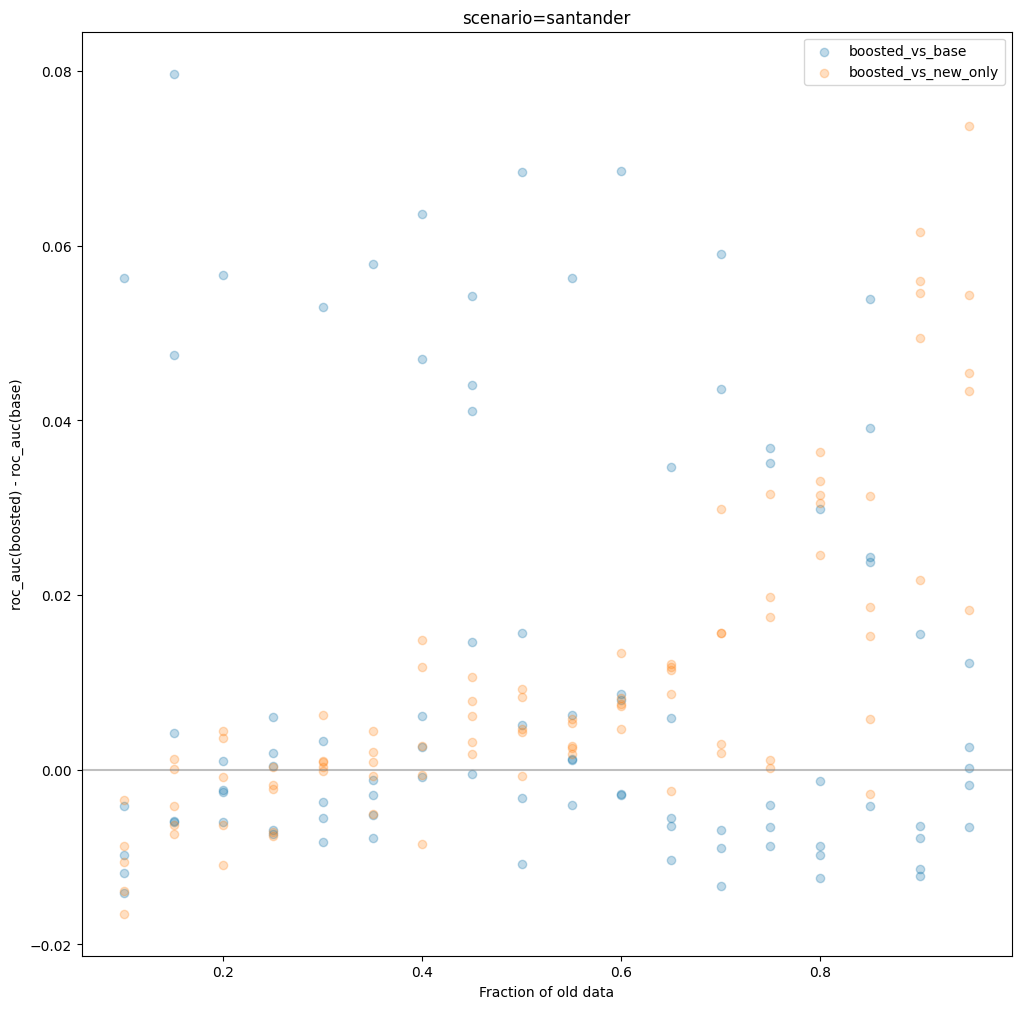

,scenario,legacy_size,base_roc_auc,boosted_roc_auc,new_only_roc_auc,full_data_auc_score,boosted_regret,base_regret,win_base,win_new_only,delta_base,delta_new_only,win_delta
0,santander,0.10,0.834889,0.825113,0.838958,0.828822,0.003709,-0.006067,False,False,-0.009776,-0.013845,-0.000000
1,santander,0.10,0.833629,0.819569,0.828247,0.828822,0.009253,-0.004807,False,False,-0.014060,-0.008678,-0.000000
2,santander,0.10,0.759922,0.816171,0.832649,0.828822,0.012651,0.068900,True,False,0.056249,-0.016478,0.056249
3,santander,0.10,0.823503,0.819319,0.822725,0.828822,0.009503,0.005319,False,False,-0.004185,-0.003406,-0.000000
4,santander,0.10,0.830375,0.818580,0.829150,0.828822,0.010242,-0.001553,False,False,-0.011795,-0.010571,-0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,santander,0.95,0.760514,0.772721,0.754407,0.828822,0.056101,0.068308,True,True,0.012207,0.018314,0.012207
86,santander,0.95,0.804547,0.804744,0.731054,0.828822,0.024078,0.024275,True,True,0.000196,0.073690,0.000196
87,santander,0.95,0.800030,0.798240,0.752864,0.828822,0.030582,0.028792,False,True,-0.001790,0.045376,-0.000000
88,santander,0.95,0.823133,0.816606,0.773229,0.828822,0.012216,0.005689,False,True,-0.006527,0.043377,-0.000000


In [40]:
scenario = 'santander'
x = result[result['scenario'] == scenario]

plt.title("scenario={}".format(scenario))
plt.scatter(x['legacy_size'], x['delta_base'], label='boosted_vs_base', alpha=0.25)
plt.scatter(x['legacy_size'], x['delta_new_only'], label='boosted_vs_new_only', alpha=0.25)
plt.axhline(0, color='gray', alpha=0.5)
plt.legend()
plt.xlabel("Fraction of old data")
plt.ylabel("roc_auc(boosted) - roc_auc(base)")

plt.show()
x

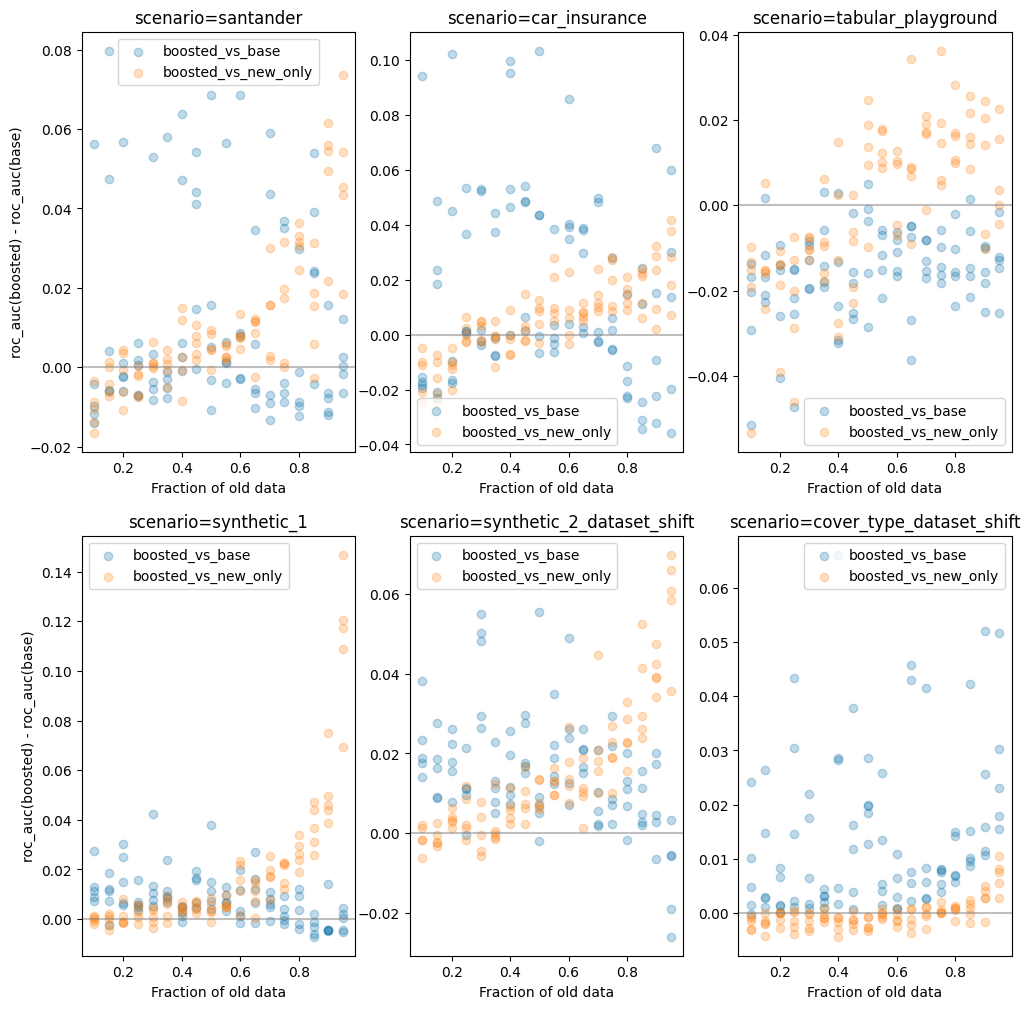

In [44]:
n_scenarios = len(SCENARIOS)
plot_cols = 3
plot_rows = int(np.ceil(n_scenarios/plot_cols))
i = 1

for scenario in SCENARIOS:
    plt.subplot(plot_rows*100+plot_cols*10+i)
    i += 1
    x = result[result['scenario'] == scenario]

    plt.title("scenario={}".format(scenario))
    plt.scatter(x['legacy_size'], x['delta_base'], label='boosted_vs_base', alpha=0.25)
    plt.scatter(x['legacy_size'], x['delta_new_only'], label='boosted_vs_new_only', alpha=0.25)
    plt.axhline(0, color='gray', alpha=0.5)
    plt.legend()
    plt.xlabel("Fraction of old data")
    if (i % 3 == 2):
        plt.ylabel("roc_auc(boosted) - roc_auc(base)")
